In [65]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from src.dataset_torch import R2HandRilDataset as ds

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [66]:
class R2HandRilNet(torch.nn.Module):
    def __init__(self):
        super(R2HandRilNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=62, kernel_size=3, padding=1)
        self.act1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(
            in_channels=62, out_channels=62, kernel_size=3, padding=1)
        self.act2 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = torch.nn.Conv2d(
            in_channels=62, out_channels=186, kernel_size=3, padding=1)
        self.act3 = torch.nn.ReLU()
        self.conv4 = torch.nn.Conv2d(
            in_channels=186, out_channels=186, kernel_size=3, padding=1)
        self.act4 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv5 = torch.nn.Conv2d(
            in_channels=186, out_channels=1080, kernel_size=3, padding=1)
        self.act5 = torch.nn.ReLU()
        self.conv6 = torch.nn.Conv2d(
            in_channels=1080, out_channels=1080, kernel_size=3, padding=1)
        self.act6 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv7 = torch.nn.Conv2d(
            in_channels=1080, out_channels=1080, kernel_size=3, padding=0)

        self.fc1 = torch.nn.Linear(1080, 1200)
        self.act7 = torch.nn.ReLU()

        self.fc2 = torch.nn.Linear(1200, 1200)
        self.act8 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(1200, 62)
        self.act9 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.act5(x)
        x = self.conv6(x)
        x = self.act6(x)
        x = self.pool3(x)

        x = self.conv7(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act7(x)

        x = self.fc2(x)
        x = self.act8(x)

        x = self.fc3(x)
        x = self.act9(x)

        return x



handrilnet = R2HandRilNet() 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
handrilnet = handrilnet.to(device)

In [67]:
loss = torch.nn.CrossEntropyLoss()   #variable parameter
optimizer = torch.optim.Adam(handrilnet.parameters(), lr=1.0e-3)

In [68]:
train_ds = ds('../R2HandRilDataset/Train')
test_ds = ds('../R2HandRilDataset/Test')


In [70]:
x_train = train_ds.data()
y_train = train_ds.targets()
x_test = test_ds.data()
y_test = test_ds.targets()

In [71]:
len(y_train), len(y_test)


(232500, 93000)

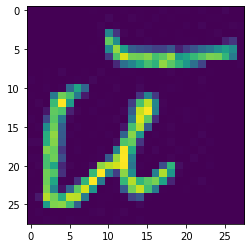

tensor(38)


In [72]:
plt.imshow(x_train[0, :, :])
plt.show()
print(y_train[0])

In [73]:
x_train = x_train.unsqueeze(1).float()
x_test = x_test.unsqueeze(1).float()

In [74]:
x_train.shape

torch.Size([232500, 1, 28, 28])

In [75]:
batch_size = 32

test_accuracy_history = []
test_loss_history = []

x_test = x_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(x_train))
    for start_index in range(0, len(x_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        x_batch = x_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = handrilnet.forward(x_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = handrilnet.forward(x_test)
    test_loss_history.append(loss(test_preds, y_test).to(device))

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().to(device)
    test_accuracy_history.append(accuracy)

    print('Epoch:', epoch + 1, 'Loss:', round(float(test_loss_history[epoch]), 4),
          'Accuracy:', round(float(accuracy), 4))

KeyboardInterrupt: 

In [ ]:
handrilnet.forward(x_test)

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(test_accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(test_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()